# Import Dependencies

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv
from tqdm import tqdm

In [ ]:
from keras.models import Sequential, load_model
from keras import layers
from keras.activations import relu
from keras.optimizers import Adam
from keras import losses
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.src.callbacks import History, ModelCheckpoint

In [ ]:
!unzip -qq /content/drive/MyDrive/datasets/utkface-new.zip

In [ ]:
DATASET_PATH: str = '/content/UTKFace'
INPUT_SHAPE: tuple[int, int, int] = (124, 124, 3)
EPOCHS: int = 30
BATCH_SIZE: int = 32
MODEL_SAVE_PATH: str = 'best_age_estimator_resnet.keras'

# Load The Dataset

In [ ]:
images_list: list[cv.typing.MatLike] = []
ages_list: list[int] = []

for image_name in tqdm(os.listdir(DATASET_PATH)):
    image_age = image_name.split('_')[0]
    ages_list.append(int(image_age))

    img = cv.imread(os.path.join(DATASET_PATH, image_name))
    img = cv.resize(img, INPUT_SHAPE[:2])
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images_list.append(img)

100%|██████████| 23708/23708 [00:16<00:00, 1477.96it/s]


In [ ]:
df: pd.DataFrame = pd.concat([
    pd.Series(images_list, name='Images'),
    pd.Series(ages_list, name='Ages')
], axis=1)

df.head()

,Images,Ages
0,"[[[98, 61, 42], [114, 76, 57], [130, 88, 70], ...",1
1,"[[[194, 157, 105], [193, 157, 105], [192, 158,...",15
2,"[[[3, 12, 11], [14, 20, 18], [27, 32, 28], [38...",20
3,"[[[30, 17, 1], [35, 22, 5], [39, 25, 7], [45, ...",35
4,"[[[130, 135, 117], [118, 125, 109], [130, 141,...",18


# Visualization And Data Cleaning

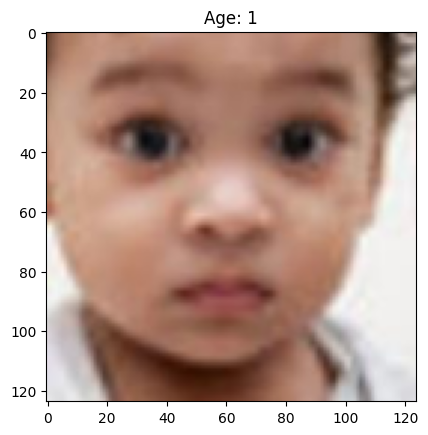

In [ ]:
plt.imshow(df['Images'][0])
age = df['Ages'][0]
plt.title(f'Age: {age}')
plt.show()

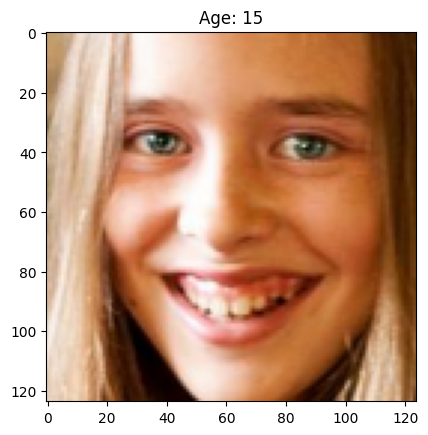

In [ ]:
plt.imshow(df['Images'][1])
age = df['Ages'][1]
plt.title(f'Age: {age}')
plt.show()

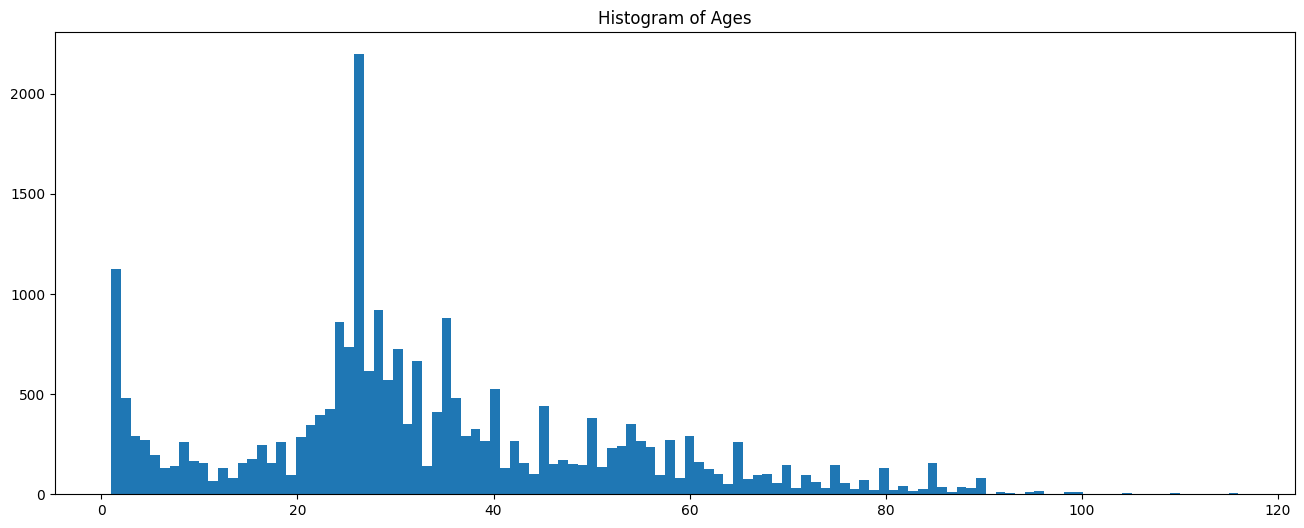

In [ ]:
plt.figure(figsize=(16, 6))
plt.hist(df['Ages'], bins=df['Ages'].max())
plt.title('Histogram of Ages')
plt.show()

In [ ]:
under_26 = df[df['Ages'] <= 26]
under_26_new = under_26.sample(frac=0.3)

up_26 = df[df['Ages'] > 26]
df = pd.concat([under_26_new, up_26], axis=0)

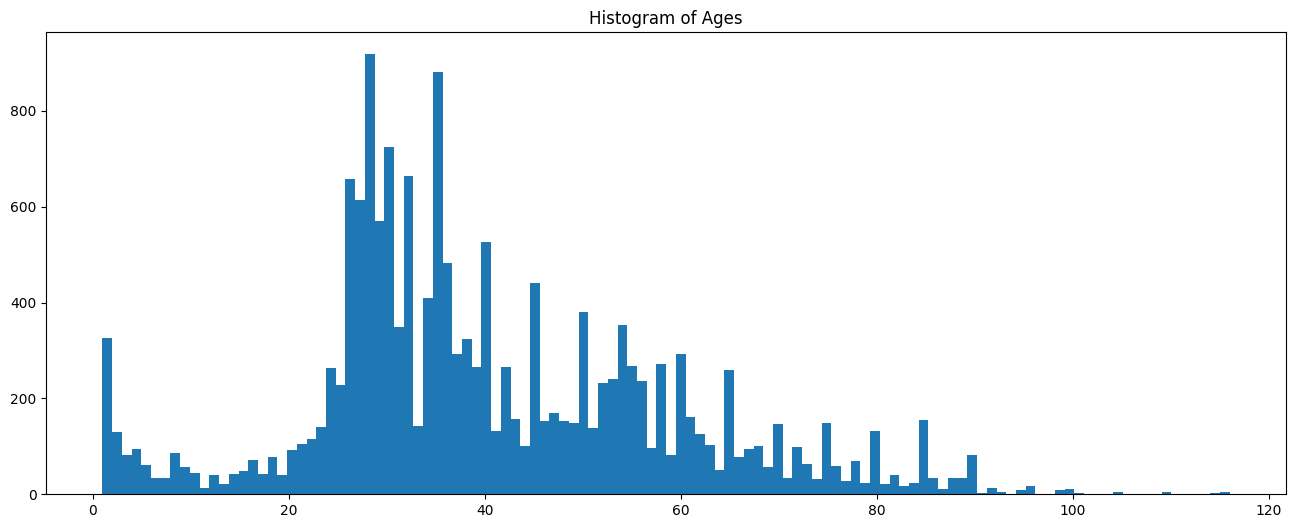

In [ ]:
plt.figure(figsize=(16, 6))
plt.hist(df['Ages'], bins=df['Ages'].max())
plt.title('Histogram of Ages')
plt.show()

In [ ]:
df = df[df['Ages'] < 80]

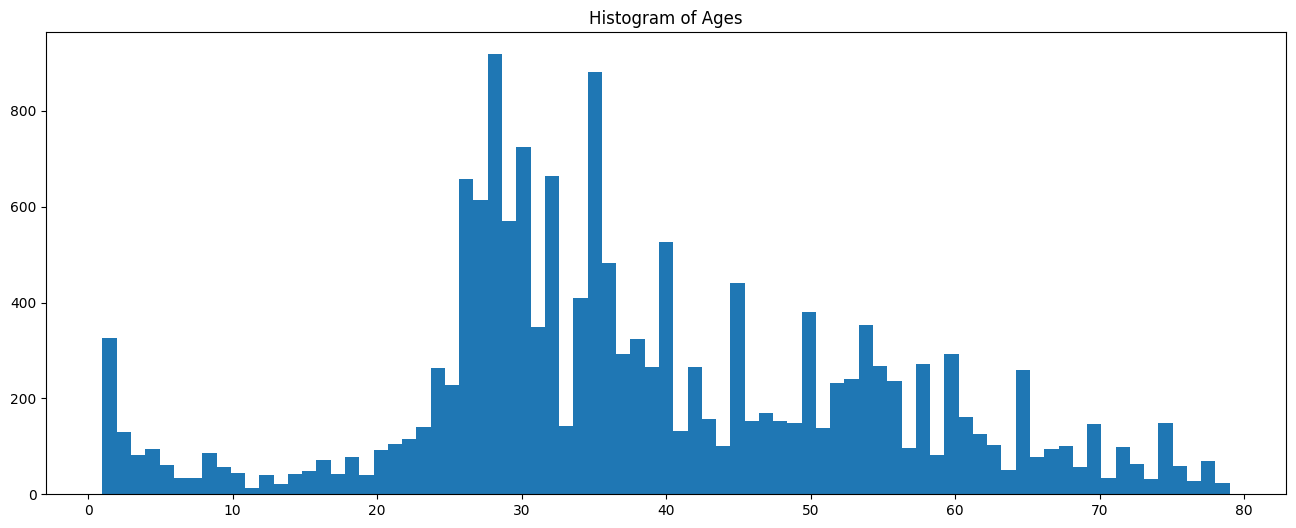

In [ ]:
plt.figure(figsize=(16, 6))
plt.hist(df['Ages'], bins=df['Ages'].max())
plt.title('Histogram of Ages')
plt.show()

In [ ]:
images = np.array(df['Images'].values.tolist())
ages = np.array(df['Ages'].values.tolist())

images.shape, ages.shape

((16151, 124, 124, 3), (16151,))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(images, ages, test_size=0.2)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((12920, 124, 124, 3), (3231, 124, 124, 3), (12920,), (3231,))

# Create The Model

In [ ]:
idg = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

train_dataset = idg.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_dataset = idg.flow(x_val, y_val, batch_size=BATCH_SIZE)

In [ ]:
resnet = ResNet50(
    include_top=False,
    input_shape=INPUT_SHAPE,
    pooling='avg'
)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model: Sequential = Sequential([
    resnet,

    layers.Flatten(name='FlattenLayer'),
    layers.Dropout(.2, name='DropoutLayer'),
    layers.Dense(1, activation=relu, name='DenseOutputLayer'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 FlattenLayer (Flatten)      (None, 2048)              0         
                                                                 
 DropoutLayer (Dropout)      (None, 2048)              0         
                                                                 
 DenseOutputLayer (Dense)    (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=losses.mae
)
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True)
# stop = EarlyStopping(patience=10)

# Train The Model And Plot The Results

In [ ]:
history: History = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/30
404/404 [==============================] - 107s 165ms/step - loss: 22.6548 - val_loss: 38.4361
Epoch 2/30
404/404 [==============================] - 63s 157ms/step - loss: 7.2473 - val_loss: 15.9457
Epoch 3/30
404/404 [==============================] - 62s 153ms/step - loss: 6.1809 - val_loss: 6.2583
Epoch 4/30
404/404 [==============================] - 60s 148ms/step - loss: 5.6982 - val_loss: 6.0715
Epoch 5/30
404/404 [==============================] - 62s 154ms/step - loss: 5.3275 - val_loss: 5.8225
Epoch 6/30
404/404 [==============================] - 60s 150ms/step - loss: 4.9732 - val_loss: 5.8533
Epoch 7/30
404/404 [==============================] - 60s 148ms/step - loss: 4.7017 - val_loss: 5.8610
Epoch 8/30
404/404 [==============================] - 61s 150ms/step - loss: 4.5361 - val_loss: 5.8667
Epoch 9/30
404/404 [==============================] - 60s 149ms/step - loss: 4.2795 - val_loss: 5.8964
Epoch 10/30
404/404 [==============================] - 65s 161ms/step

In [ ]:
model: Sequential = load_model(MODEL_SAVE_PATH)
model.evaluate(val_dataset)

101/101 [==============================] - 5s 40ms/step - loss: 5.6116


5.611562728881836

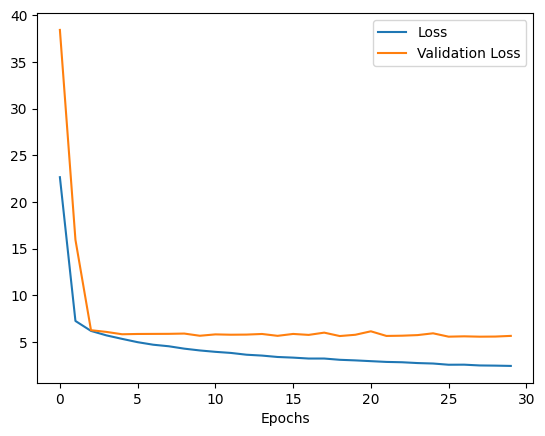

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.legend(['Loss','Validation Loss'], loc='upper right')
plt.show()

# Inference

In [14]:
import tensorflow as tf
from keras.models import Sequential, load_model

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from face_detector import FaceDetector

In [4]:
MODEL_SAVE_PATH: str = './best_age_estimator_resnet.keras'
INPUT_SHAPE: tuple[int, int, int] = (124, 124, 3)

In [6]:
model: Sequential = load_model(MODEL_SAVE_PATH)

In [8]:
def estimate(img) -> np.ndarray:
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, INPUT_SHAPE[:2])
    img = img / 255.

    img = img[tf.newaxis, ...]

    return model.predict(img)

In [9]:
!wget https://fcb-abj-pre.s3.amazonaws.com/img/jugadors/MESSI.jpg

--2024-04-13 16:56:45--  https://fcb-abj-pre.s3.amazonaws.com/img/jugadors/MESSI.jpg
Resolving fcb-abj-pre.s3.amazonaws.com (fcb-abj-pre.s3.amazonaws.com)... 52.218.46.41, 52.218.90.130, 52.92.20.9, ...
Connecting to fcb-abj-pre.s3.amazonaws.com (fcb-abj-pre.s3.amazonaws.com)|52.218.46.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107778 (105K) [application/octet-stream]
Saving to: ‘MESSI.jpg’

MESSI.jpg           100%[===================>] 105.25K   483KB/s    in 0.2s    

2024-04-13 16:56:45 (483 KB/s) - ‘MESSI.jpg’ saved [107778/107778]


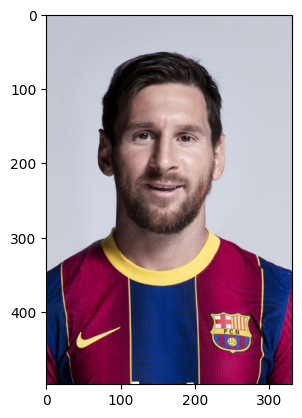

In [22]:
img = cv.imread('MESSI.jpg')
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

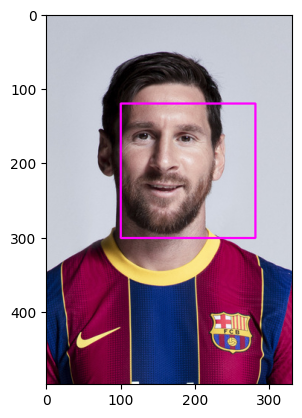

In [23]:
detector = FaceDetector()

detector_result, bbox = detector.detect_face(img, draw=True)
plt.imshow(cv.cvtColor(detector_result, cv.COLOR_BGR2RGB))
plt.show()

1/1 [==============================] - 0s 43ms/step


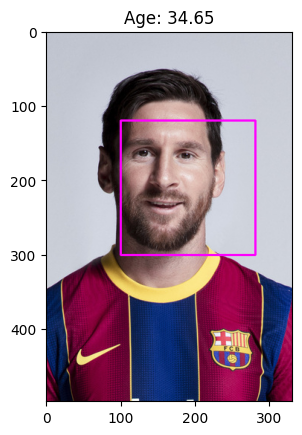

In [29]:
if len(bbox) > 0:
    x1, y1, x2, y2 = bbox[0]

    face = img[y1: y2, x1: x2]
    age = estimate(face)

    plt.title(f'Age: {round(float(age[0][0]), 2)}')
    plt.imshow(cv.cvtColor(detector_result, cv.COLOR_BGR2RGB))
    plt.show()
else:
    print('No Face Detected')